FX RISK PORTFOLIO ANALYSIS & HEDGING OPTIMIZATION

[1/7] Generating FX market data and portfolio exposure...
✓ Generated 252 days of FX rates for 6 currency pairs

Current FX Rates:
Date     2024-12-17
EUR/USD    1.109015
GBP/USD    1.374666
USD/JPY   97.029066
AUD/USD    1.059649
USD/CHF    1.050078
USD/CAD    1.495578

PORTFOLIO EXPOSURES
Currency_Pair  Exposure_USD_M Exposure_Type
      EUR/USD              50          Long
      GBP/USD              30          Long
      USD/JPY             -40         Short
      AUD/USD              20          Long
      USD/CHF             -15         Short
      USD/CAD              25          Long

Net Exposure: $70.0M

[2/7] Calculating returns and volatility metrics...

FX Pair Statistics:
Currency_Pair  Annual_Return  Annual_Volatility  Sharpe_Ratio
      EUR/USD       1.285841           9.683601      0.132785
      GBP/USD       7.884142          12.024483      0.655674
      USD/JPY     -12.285545           7.866142     -1.561826
     

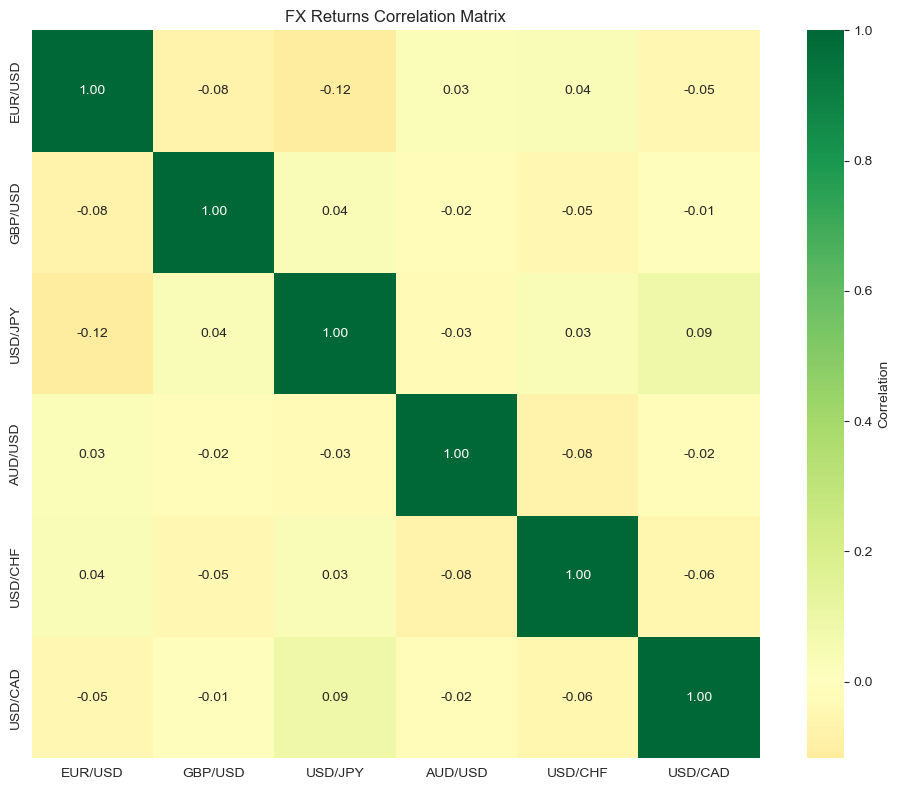


[3/7] Visualizing FX rate movements...


FileNotFoundError: [Errno 2] No such file or directory: 'images/images/fx_rate_movements.png'

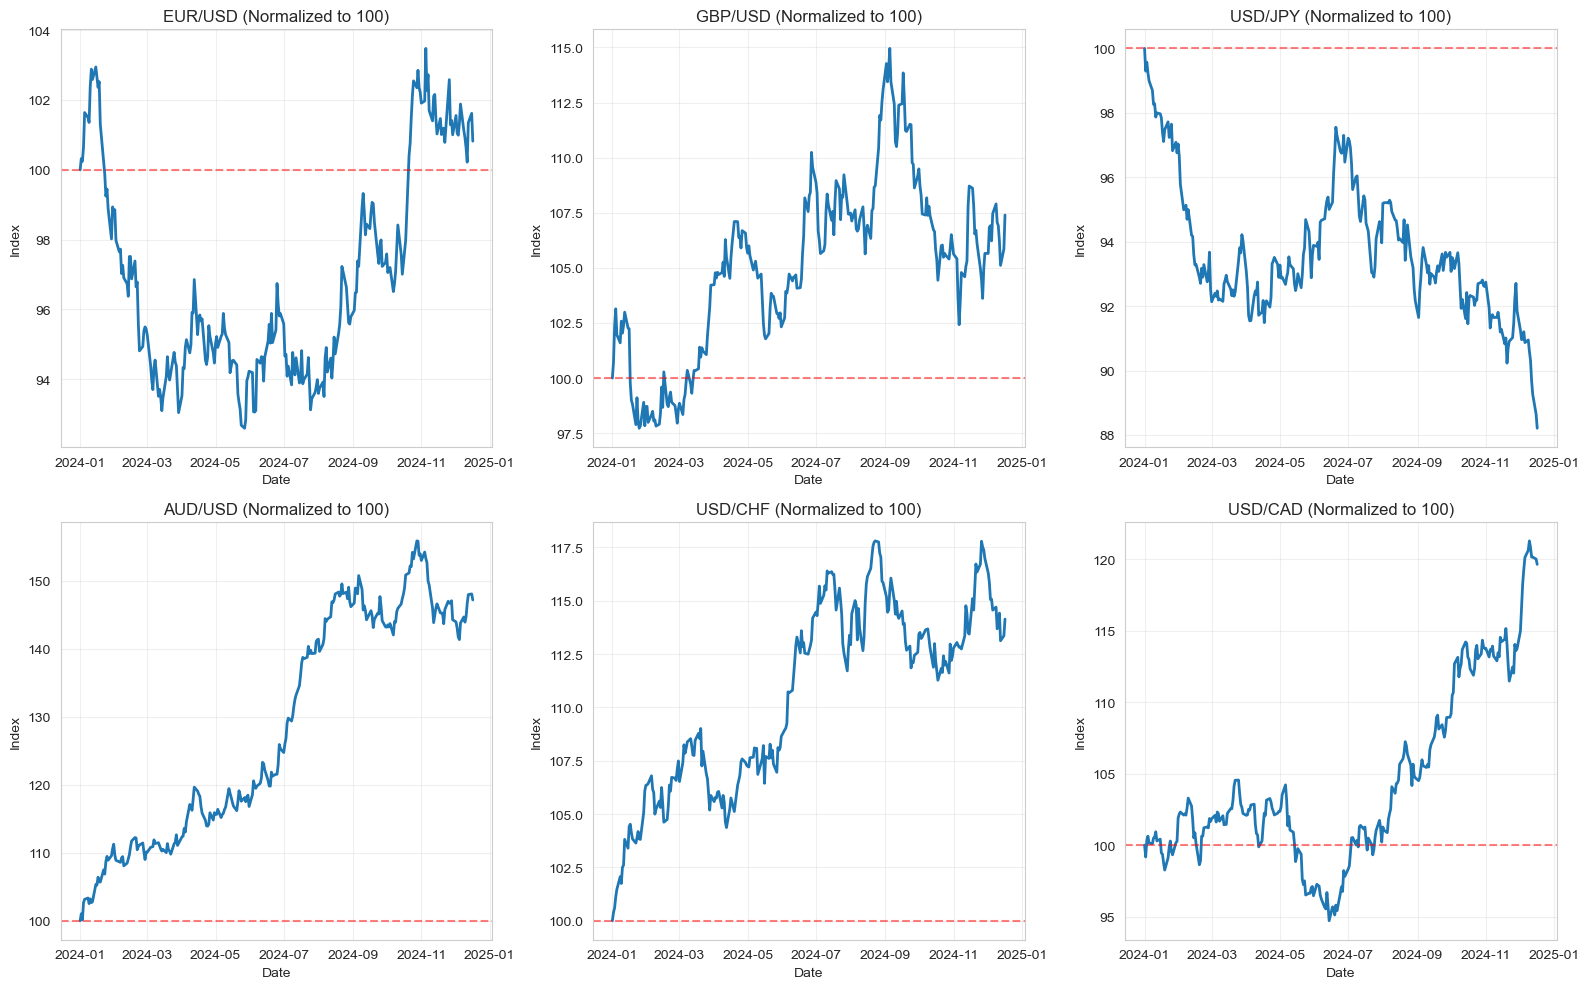

In [3]:
# ===== FX RISK PORTFOLIO ANALYSIS =====
# Author: Suzy Tang
# Goal: Analyze foreign exchange exposure and optimize hedging strategies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*70)
print("FX RISK PORTFOLIO ANALYSIS & HEDGING OPTIMIZATION")
print("="*70)

# ===== 1. GENERATE FX MARKET DATA =====
print("\n[1/7] Generating FX market data and portfolio exposure...")

np.random.seed(42)

# Define currency pairs
currency_pairs = ['EUR/USD', 'GBP/USD', 'USD/JPY', 'AUD/USD', 'USD/CHF', 'USD/CAD']
n_days = 252  # One trading year

# Generate synthetic FX rates using geometric Brownian motion
def generate_fx_rates(initial_rate, mu, sigma, n_days):
    """Generate FX rates using GBM"""
    dt = 1/252  # Daily time step
    rates = [initial_rate]
    
    for _ in range(n_days - 1):
        drift = mu * dt
        shock = sigma * np.sqrt(dt) * np.random.normal()
        new_rate = rates[-1] * np.exp(drift + shock)
        rates.append(new_rate)
    
    return np.array(rates)

# Initial rates and parameters
fx_params = {
    'EUR/USD': {'initial': 1.10, 'mu': 0.02, 'sigma': 0.10},
    'GBP/USD': {'initial': 1.28, 'mu': 0.01, 'sigma': 0.12},
    'USD/JPY': {'initial': 110.0, 'mu': -0.01, 'sigma': 0.08},
    'AUD/USD': {'initial': 0.72, 'mu': 0.03, 'sigma': 0.15},
    'USD/CHF': {'initial': 0.92, 'mu': -0.02, 'sigma': 0.09},
    'USD/CAD': {'initial': 1.25, 'mu': 0.01, 'sigma': 0.11}
}

# Generate rates
dates = pd.date_range(start='2024-01-01', periods=n_days, freq='B')
fx_data = pd.DataFrame({'Date': dates})

for pair, params in fx_params.items():
    fx_data[pair] = generate_fx_rates(
        params['initial'], 
        params['mu'], 
        params['sigma'], 
        n_days
    )

fx_data.set_index('Date', inplace=True)

print(f"✓ Generated {n_days} days of FX rates for {len(currency_pairs)} currency pairs")
print("\nCurrent FX Rates:")
print(fx_data.tail(1).T)

# Portfolio exposures (in millions)
exposures = pd.DataFrame({
    'Currency_Pair': currency_pairs,
    'Exposure_USD_M': [50, 30, -40, 20, -15, 25],  # Negative = short position
    'Exposure_Type': ['Long', 'Long', 'Short', 'Long', 'Short', 'Long']
})

print("\n" + "="*70)
print("PORTFOLIO EXPOSURES")
print("="*70)
print(exposures.to_string(index=False))
print(f"\nNet Exposure: ${exposures['Exposure_USD_M'].sum():.1f}M")

# ===== 2. CALCULATE RETURNS AND VOLATILITY =====
print("\n[2/7] Calculating returns and volatility metrics...")

# Daily returns
returns = fx_data.pct_change().dropna()

# Annualized statistics
annual_return = returns.mean() * 252
annual_vol = returns.std() * np.sqrt(252)

stats_df = pd.DataFrame({
    'Currency_Pair': currency_pairs,
    'Annual_Return': annual_return.values * 100,
    'Annual_Volatility': annual_vol.values * 100,
    'Sharpe_Ratio': (annual_return / annual_vol).values
})

print("\nFX Pair Statistics:")
print(stats_df.to_string(index=False))

# Correlation matrix
corr_matrix = returns.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, 
            fmt='.2f', square=True, cbar_kws={'label': 'Correlation'})
plt.title('FX Returns Correlation Matrix')
plt.tight_layout()
plt.savefig('fx_correlation_matrix.png', dpi=100, bbox_inches='tight')
plt.show()

# ===== 3. VISUALIZE FX RATE MOVEMENTS =====
print("\n[3/7] Visualizing FX rate movements...")

# Normalize rates for comparison
fx_normalized = fx_data / fx_data.iloc[0] * 100

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, pair in enumerate(currency_pairs):
    axes[idx].plot(fx_normalized.index, fx_normalized[pair], linewidth=2)
    axes[idx].set_title(f'{pair} (Normalized to 100)')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Index')
    axes[idx].grid(alpha=0.3)
    axes[idx].axhline(y=100, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('images/fx_rate_movements.png', dpi=100, bbox_inches='tight')
plt.show()

# ===== 4. VALUE AT RISK (VaR) ANALYSIS =====
print("\n[4/7] Calculating Value at Risk (VaR)...")

# Portfolio returns calculation
portfolio_returns = pd.Series(0, index=returns.index)

for idx, row in exposures.iterrows():
    pair = row['Currency_Pair']
    exposure = row['Exposure_USD_M']
    portfolio_returns += returns[pair] * exposure

# Historical VaR
confidence_levels = [0.95, 0.99]
var_results = {}

for conf in confidence_levels:
    var_historical = np.percentile(portfolio_returns, (1 - conf) * 100)
    var_results[f'VaR_{int(conf*100)}'] = var_historical

print("\n" + "="*70)
print("VALUE AT RISK (VaR) ANALYSIS")
print("="*70)
print(f"1-Day VaR (95% confidence): ${var_results['VaR_95']:.2f}M")
print(f"1-Day VaR (99% confidence): ${var_results['VaR_99']:.2f}M")

# Calculate CVaR (Conditional VaR / Expected Shortfall)
cvar_95 = portfolio_returns[portfolio_returns <= var_results['VaR_95']].mean()
cvar_99 = portfolio_returns[portfolio_returns <= var_results['VaR_99']].mean()

print(f"\n1-Day CVaR (95% confidence): ${cvar_95:.2f}M")
print(f"1-Day CVaR (99% confidence): ${cvar_99:.2f}M")

# VaR visualization
plt.figure(figsize=(12, 6))
plt.hist(portfolio_returns, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(var_results['VaR_95'], color='red', linestyle='--', linewidth=2, 
            label=f"VaR 95%: ${var_results['VaR_95']:.2f}M")
plt.axvline(var_results['VaR_99'], color='darkred', linestyle='--', linewidth=2, 
            label=f"VaR 99%: ${var_results['VaR_99']:.2f}M")
plt.xlabel('Daily P&L ($ Millions)')
plt.ylabel('Frequency')
plt.title('Portfolio P&L Distribution with VaR')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('images/fx_var_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

# ===== 5. RISK DECOMPOSITION =====
print("\n[5/7] Performing risk decomposition analysis...")

# Calculate contribution to portfolio variance
weights = exposures['Exposure_USD_M'].values / exposures['Exposure_USD_M'].abs().sum()
cov_matrix = returns.cov() * 252  # Annualized covariance

portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_vol = np.sqrt(portfolio_variance)

# Marginal contribution to risk
marginal_contrib = np.dot(cov_matrix, weights) / portfolio_vol

# Component contribution to risk
component_contrib = weights * marginal_contrib

risk_contrib = pd.DataFrame({
    'Currency_Pair': currency_pairs,
    'Weight': weights * 100,
    'Marginal_Risk': marginal_contrib * 100,
    'Risk_Contribution': component_contrib * 100,
    'Risk_Contribution_Pct': (component_contrib / component_contrib.sum()) * 100
})

print("\n" + "="*70)
print("RISK DECOMPOSITION")
print("="*70)
print(f"Portfolio Volatility: {portfolio_vol*100:.2f}%\n")
print(risk_contrib.to_string(index=False))

# Risk contribution chart
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in risk_contrib['Risk_Contribution_Pct']]
plt.barh(risk_contrib['Currency_Pair'], risk_contrib['Risk_Contribution_Pct'], color=colors)
plt.xlabel('Risk Contribution (%)')
plt.ylabel('Currency Pair')
plt.title('Component Contribution to Portfolio Risk')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('images/fx_risk_decomposition.png', dpi=100, bbox_inches='tight')
plt.show()

# ===== 6. OPTIMAL HEDGING STRATEGY =====
print("\n[6/7] Calculating optimal hedging strategy...")

# Define optimization problem: minimize portfolio variance
def portfolio_volatility(hedge_ratios):
    """Calculate portfolio volatility given hedge ratios"""
    hedged_weights = weights * (1 - hedge_ratios)
    hedged_variance = np.dot(hedged_weights.T, np.dot(cov_matrix, hedged_weights))
    return np.sqrt(hedged_variance)

# Constraints: hedge ratios between 0 and 1
bounds = tuple((0, 1) for _ in range(len(currency_pairs)))
initial_guess = np.zeros(len(currency_pairs))

# Optimize
result = minimize(
    portfolio_volatility,
    initial_guess,
    method='SLSQP',
    bounds=bounds
)

optimal_hedges = result.x

# Calculate hedging impact
original_vol = portfolio_vol
hedged_vol = result.fun

hedging_strategy = pd.DataFrame({
    'Currency_Pair': currency_pairs,
    'Current_Exposure_M': exposures['Exposure_USD_M'].values,
    'Optimal_Hedge_Ratio': optimal_hedges * 100,
    'Hedge_Amount_M': exposures['Exposure_USD_M'].values * optimal_hedges,
    'Net_Exposure_M': exposures['Exposure_USD_M'].values * (1 - optimal_hedges)
})

print("\n" + "="*70)
print("OPTIMAL HEDGING STRATEGY")
print("="*70)
print(f"Original Portfolio Volatility: {original_vol*100:.2f}%")
print(f"Hedged Portfolio Volatility: {hedged_vol*100:.2f}%")
print(f"Volatility Reduction: {(1 - hedged_vol/original_vol)*100:.1f}%\n")
print(hedging_strategy.to_string(index=False))

# Hedging visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Before/After exposure
x = np.arange(len(currency_pairs))
width = 0.35

ax1.bar(x - width/2, exposures['Exposure_USD_M'], width, 
        label='Original Exposure', color='coral')
ax1.bar(x + width/2, hedging_strategy['Net_Exposure_M'], width, 
        label='After Hedging', color='lightblue')
ax1.set_xlabel('Currency Pair')
ax1.set_ylabel('Exposure ($ Millions)')
ax1.set_title('FX Exposure: Before vs After Hedging')
ax1.set_xticks(x)
ax1.set_xticklabels(currency_pairs, rotation=45, ha='right')
ax1.legend()
ax1.axhline(y=0, color='black', linewidth=0.5)
ax1.grid(alpha=0.3, axis='y')

# Hedge ratios
ax2.barh(currency_pairs, optimal_hedges * 100, color='steelblue')
ax2.set_xlabel('Optimal Hedge Ratio (%)')
ax2.set_ylabel('Currency Pair')
ax2.set_title('Recommended Hedge Ratios')
ax2.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('images/fx_hedging_strategy.png', dpi=100, bbox_inches='tight')
plt.show()

# ===== 7. SCENARIO ANALYSIS =====
print("\n[7/7] Running stress test scenarios...")

# Define stress scenarios
scenarios = {
    'USD Strength': {'EUR/USD': -0.10, 'GBP/USD': -0.08, 'USD/JPY': 0.10, 
                     'AUD/USD': -0.12, 'USD/CHF': 0.08, 'USD/CAD': 0.09},
    'USD Weakness': {'EUR/USD': 0.10, 'GBP/USD': 0.08, 'USD/JPY': -0.10, 
                     'AUD/USD': 0.12, 'USD/CHF': -0.08, 'USD/CAD': -0.09},
    'Market Turmoil': {'EUR/USD': -0.15, 'GBP/USD': -0.15, 'USD/JPY': 0.15, 
                       'AUD/USD': -0.20, 'USD/CHF': 0.12, 'USD/CAD': 0.15},
    'Risk-On': {'EUR/USD': 0.05, 'GBP/USD': 0.06, 'USD/JPY': -0.05, 
                'AUD/USD': 0.10, 'USD/CHF': -0.04, 'USD/CAD': -0.06}
}

scenario_results = []

for scenario_name, shocks in scenarios.items():
    # Calculate P&L impact
    pnl_original = sum(exposures['Exposure_USD_M'][i] * shocks[pair] 
                       for i, pair in enumerate(currency_pairs))
    
    pnl_hedged = sum(hedging_strategy['Net_Exposure_M'][i] * shocks[pair] 
                     for i, pair in enumerate(currency_pairs))
    
    scenario_results.append({
        'Scenario': scenario_name,
        'Original_PnL_M': pnl_original,
        'Hedged_PnL_M': pnl_hedged,
        'Benefit_M': pnl_original - pnl_hedged
    })

scenario_df = pd.DataFrame(scenario_results)

print("\n" + "="*70)
print("STRESS TEST SCENARIOS")
print("="*70)
print(scenario_df.to_string(index=False))

# Scenario visualization
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(scenario_df))
width = 0.35

bars1 = ax.bar(x - width/2, scenario_df['Original_PnL_M'], width, 
               label='Original Portfolio', color='coral')
bars2 = ax.bar(x + width/2, scenario_df['Hedged_PnL_M'], width, 
               label='Hedged Portfolio', color='lightblue')

ax.set_xlabel('Scenario')
ax.set_ylabel('P&L Impact ($ Millions)')
ax.set_title('Stress Test: P&L Impact by Scenario')
ax.set_xticks(x)
ax.set_xticklabels(scenario_df['Scenario'])
ax.legend()
ax.axhline(y=0, color='black', linewidth=0.8)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('images/fx_stress_scenarios.png', dpi=100, bbox_inches='tight')
plt.show()

# ===== SUMMARY & RECOMMENDATIONS =====
print("\n" + "="*70)
print("KEY INSIGHTS & RECOMMENDATIONS")
print("="*70)

highest_risk_pair = risk_contrib.loc[risk_contrib['Risk_Contribution_Pct'].abs().idxmax(), 'Currency_Pair']
highest_hedge_pair = hedging_strategy.loc[hedging_strategy['Optimal_Hedge_Ratio'].idxmax(), 'Currency_Pair']
worst_scenario = scenario_df.loc[scenario_df['Original_PnL_M'].idxmin(), 'Scenario']

print(f"""
1. PORTFOLIO RISK METRICS:
   - Current Portfolio Volatility: {original_vol*100:.2f}%
   - 1-Day VaR (95%): ${var_results['VaR_95']:.2f}M
   - 1-Day CVaR (95%): ${cvar_95:.2f}M
   
2. KEY RISK CONTRIBUTORS:
   - Highest Risk Contributor: {highest_risk_pair}
   - Largest Exposure: {exposures.loc[exposures['Exposure_USD_M'].abs().idxmax(), 'Currency_Pair']}
   - Net Portfolio Exposure: ${exposures['Exposure_USD_M'].sum():.1f}M
   
3. HEDGING RECOMMENDATIONS:
   - Implement optimal hedging strategy to reduce volatility by {(1-hedged_vol/original_vol)*100:.1f}%
   - Priority hedge: {highest_hedge_pair} ({hedging_strategy.loc[hedging_strategy['Optimal_Hedge_Ratio'].idxmax(), 'Optimal_Hedge_Ratio']:.1f}%)
   - Total hedging cost: ${hedging_strategy['Hedge_Amount_M'].abs().sum():.1f}M notional
   
4. STRESS TEST INSIGHTS:
   - Worst scenario: {worst_scenario} (${scenario_df.loc[scenario_df['Original_PnL_M'].idxmin(), 'Original_PnL_M']:.1f}M loss)
   - Hedging reduces worst-case loss by ${abs(scenario_df.loc[scenario_df['Original_PnL_M'].idxmin(), 'Benefit_M']):.1f}M
   - Consider dynamic hedging for high-volatility pairs
   
5. ACTION ITEMS:
   - Monitor correlations daily for diversification benefits
   - Review hedge ratios monthly or after significant market moves
   - Implement VaR limits at desk level
   - Consider using FX options for asymmetric protection
""")

# Save results
hedging_strategy.to_csv('fx_hedging_recommendations.csv', index=False)
scenario_df.to_csv('fx_stress_scenarios.csv', index=False)

print("\n✅ FX Risk Portfolio Analysis Complete!")
print("="*70)